In [2]:
import numpy as np
import os
import utils.load_data 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import utils.feature 
from filterpy.kalman import KalmanFilter

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

path = "data1/2、不同浓度下甲醛和乙醇"
data_dict = utils.load_data.read_data(path)

class_num = len(list(data_dict.keys()))                
for key, value in data_dict.items():
    print(key, )


自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/30%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5249, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/40%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/50%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/60%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇/70%RH C2H6O 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm乙醇 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/30%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/40%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/50%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛/60%RH HCHO 0.1.txt ----> data1/2、不同浓度下甲醛和乙醇\0.1 ppm甲醛 (5250, 5)
自动检测出时间序列，已处理,data1/2、不同浓度下甲醛和乙醇

5249
5250
5250
5250
5250
5250
5250
5250
5250
5250


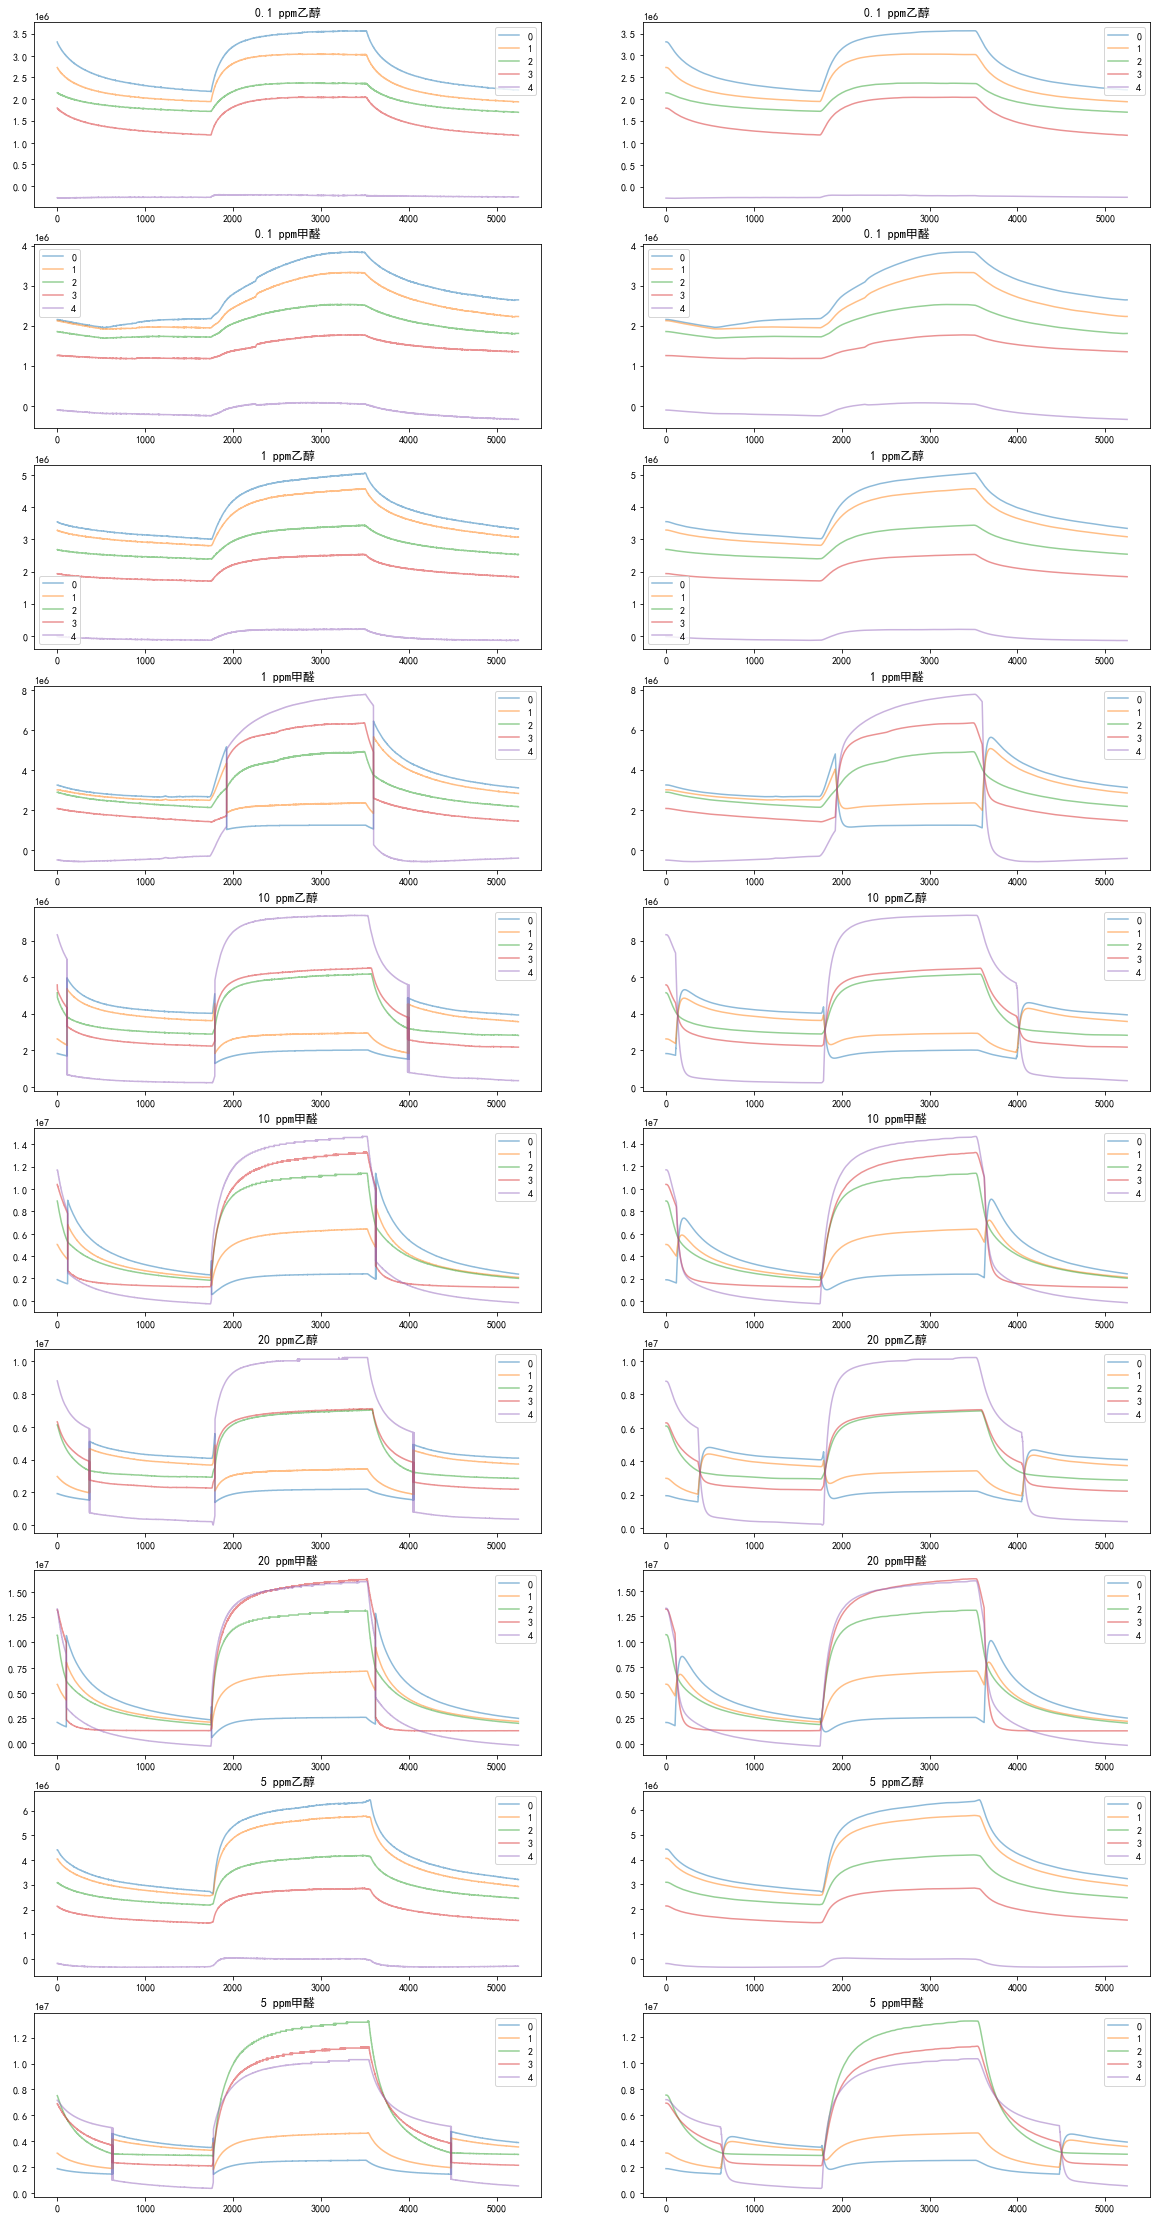

In [3]:

def kalmanf(signal, noise_R=66):
    filtered_sig = []
    dim_z = dim_x = signal.shape[1]
    f = KalmanFilter(dim_x=dim_x, dim_z=dim_z)

    f.x = np.array(signal[0, :])  # 初始值
    f.F = np.eye(dim_x)  # 状态转移
    f.H = np.eye(dim_x) * 1  # 测量矩阵
    f.P = np.eye(dim_x) * 1  # 协方差
    f.R = np.eye(dim_x) * noise_R  # 测量误差
    for i in signal:
        f.update(i)
        f.predict()
        filtered_sig.append(f.x)
    print(len(filtered_sig))
    return np.array(filtered_sig)


# scaler = StandardScaler()
plt.figure(figsize=[20,40])
for i ,key in enumerate(list(data_dict.keys())):
    ax = plt.subplot2grid((class_num,2), (i,0))
    data_num = len(list(data_dict[key]))
    data_show = data_dict[key][np.random.randint(0,data_num)]
    # data_show = scaler.fit_transform(data_show)
    for j in range(data_show.shape[1]): 
        ax.plot(range(data_show.shape[0]),data_show[:,j],label = j,alpha = 0.5)
    ax.set_title(key)
    ax.legend()

    ax = plt.subplot2grid((class_num,2), (i,1))
    data_show = kalmanf(data_show,noise_R=1000)
    # data_show = scaler.fit_transform(data_show)
    for j in range(data_show.shape[1]): 
        ax.plot(range(data_show.shape[0]),data_show[:,j],label = j,alpha = 0.5)
    ax.set_title(key)
    ax.legend()


plt.show()

看起来用什么滤波都救不了了……

# 用roc aur那一套判断lda分类准确率
由于样本较少，将随机抽一个样本做为测试集，全部随机一遍过后做平均

In [4]:
from functools import reduce

def change2feature(data_dict,sig_index):
    """
    data_dict:正常的数据
    sig_index:要删除的信号列
    """
    assert sig_index<len(list(data_dict[key]))
    data_feature_dict = {}
    for i in data_dict.items():
        featured_data_list = []
        for j in i[1]:
            j = np.delete(j,sig_index,axis=1)
            feature_data = utils.feature.get_all_feature(j)
            featured_data_list.append(feature_data)
        data_feature_dict[i[0]]=featured_data_list
    return data_feature_dict

In [5]:
sig2test = 0
feature_dict = change2feature(data_dict,0)

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def get_class_scores(data_feature_dict):
    data_score_dict ={}
    pass
    return data_score_dict

def get_score(all_data,all_labels,test_data):
    scaler = StandardScaler()
    all_data = scaler.fit_transform(all_data)
    test_data = scaler.transform([test_data])
    clf = LinearDiscriminantAnalysis()
    clf.fit(all_data, all_labels)
    predict = clf.predict(test_data)
    scores = clf.predict_proba(test_data)
    return scores,predict

data_score_dict = {}
all_feature = np.concatenate(list(feature_dict.values()),axis=0)
all_labels = reduce(lambda x, y: x+y, [[key]*len(value) for key,value in feature_dict.items()])
for data_index,label in enumerate(all_labels):
    test_data = all_feature[data_index,:]
    test_feature  = np.delete(all_feature,data_index,axis=0)
    test_labels  = np.delete(all_labels,data_index,axis=0)
    scores,predict = get_score(test_feature,test_labels,test_data)
    
    if label not in data_score_dict:
        data_score_dict[label]=scores[0]
    else:
        data_score_dict[label]+=scores[0]
    # print(data_index,label,predict,scores[0])

for key,values in feature_dict.items():
    data_score_dict[key] = data_score_dict[key]/len(values)

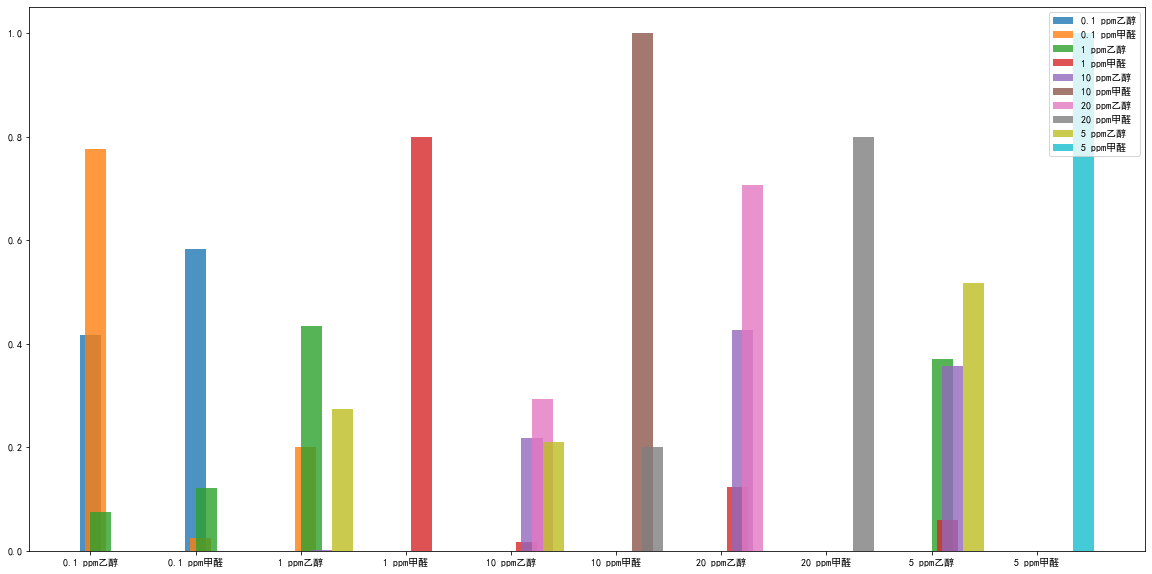

In [7]:
fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot()
for i,(key, value) in enumerate( data_score_dict.items()):
    data_show = data_score_dict[key]
    # data_show = scaler.fit_transform(data_show)
    ax.bar(np.arange(data_show.shape[0])+0.05*i,data_show[:],label =key,alpha =0.8,width=0.2)
my_label = list(data_score_dict.keys())
ax.legend()
plt.xticks(range(len(my_label)),my_label)
plt.show()

In [138]:
from sklearn.metrics import log_loss
y_score = np.array(list(data_score_dict.values()))
y_test = np.eye(class_num)
log_loss(y_true=y_test,y_pred=y_score)

0.8420373500390441